#Wine Quality Prediction through SVM and LR
- Data Exploration and Preprocessing

    - Explore the dataset thoroughly and provide a summary of your observations.
    - Perform necessary preprocessing steps:
        * Preparing feature values to be used by your models.
        * Optionally, data augmentation techniques.
        * Splitting the data into training and test sets appropriately.

- SVM and LR Implementation
    - Implement both SVM and LR from scratch. Evaluate and compare their performance.
    - Clearly define the two models and describe your implementation, also listing their hyperparameters if any.
    - Train the two models using an appropriate performance metric.
    - Demonstrate proper hyperparameter tuning, and evaluate at least one of your models using accuracy estimates via 5-fold cross-validation.

- Kernel Methods
    - Extend the above models to a kernelized form by adopting non-linear kernels.
    - Clearly describe how the kernelization happens and its consequences for both predictions and performance.
    - Comment on how the kernelized models compare with respect to the standard ones.

- Evaluation and Analysis
    - Evaluate your model performance using suitable metrics such as accuracy, precision, recall, and F1-score.
    - Provide appropriate visualizations of the performance of each model (loss and accuracy).
    - When reasonable, conduct an analysis of misclassified examples to understand potential model limitations.
    - Discuss the presence or absence of overfitting and underfitting at any point.

In [84]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
#to output plots within the notebook
%matplotlib inline

import importlib
import inspect
import os
import sys

%cd /content/
!ls -R
repo_name = "WineQualityPrediction"
#!rm -rf {repo_name}
if not os.path.exists(repo_name):
    print(f"Directory {repo_name} does not exist, proceeding with clone.")
    !git clone https://github.com/Abudo-S/WineQualityPrediction.git

%cd WineQualityPrediction


import PCA as PCA_Module
import SVM as SVM_Module
import LogisticRegression as LogisticRegression_Module
importlib.reload(PCA_Module) # in case of updates
importlib.reload(SVM_Module) # in case of updates
importlib.reload(LogisticRegression_Module) # in case of updates
from PCA import PCA
from SVM import SVM
from LogisticRegression import LogisticRegression

/content
.:
sample_data  WineQualityPrediction

./sample_data:
anscombe.json		      mnist_test.csv
california_housing_test.csv   mnist_train_small.csv
california_housing_train.csv  README.md

./WineQualityPrediction:
LogisticRegression.py  __pycache__  wine+quality
PCA.py		       SVM.py	    WineQualityPrediction.ipynb

./WineQualityPrediction/__pycache__:
LogisticRegression.cpython-311.pyc  PCA.cpython-311.pyc  SVM.cpython-311.pyc

./WineQualityPrediction/wine+quality:
winequality.names  winequality-red.csv	winequality-white.csv
Directory WineQualityPrediction does not exist, proceeding with clone.
Cloning into 'WineQualityPrediction'...
remote: Enumerating objects: 77, done.
remote: Counting objects: 100% (77/77), done.
remote: Compressing objects: 100% (63/63), done.
remote: Total 77 (delta 24), reused 48 (delta 12), pack-reused 0 (from 0)
Receiving objects: 100% (77/77), 688.76 KiB | 6.96 MiB/s, done.
Resolving deltas: 100% (24/24), done.
/content/WineQualityPrediction


# General observations:
- The red-wine dataset as well as the white-wine dataset have the same features labeled with the same target feature "quality".
- All feature values are numeric with no NaN values.
- Both datasets contain some duplicated instances.
- We'd need to combine both datasets in order to develop a universal model for both of red and white wines, by introducing a new feature 'wine_type' valorized with 1: for red wine instance, 0: for white wine instance.
In fact, introducing a new feature for the wine type the learning model would be to build relationships between the wine type and the other features.
By combining both datasets, we're increasing the training-set volume which gives the possibility to the learning model to see further records, so it reduces the risk of overfitting.

In [64]:
red_wine_quality = pd.read_csv("/content/WineQualityPrediction/wine+quality/winequality-red.csv", sep=';')
red_wine_quality.info()

white_wine_quality = pd.read_csv("/content/WineQualityPrediction/wine+quality/winequality-white.csv", sep=';')
white_wine_quality.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599 entries, 0 to 1598
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         1599 non-null   float64
 1   volatile acidity      1599 non-null   float64
 2   citric acid           1599 non-null   float64
 3   residual sugar        1599 non-null   float64
 4   chlorides             1599 non-null   float64
 5   free sulfur dioxide   1599 non-null   float64
 6   total sulfur dioxide  1599 non-null   float64
 7   density               1599 non-null   float64
 8   pH                    1599 non-null   float64
 9   sulphates             1599 non-null   float64
 10  alcohol               1599 non-null   float64
 11  quality               1599 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 150.0 KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4898 entries, 0 to 4897
Data columns (total 12 columns):
 #   Column        

Introduce categorical feature "wine_type" in red_wine_quality and white_wine_quality datasets

In [65]:
red_wine_quality['wine_type'] = 1 #red wine
white_wine_quality['wine_type'] = -1 #white wine

Combine red_wine_quality and white_wine_quality datasets

In [66]:
wine_quality = pd.concat([red_wine_quality, white_wine_quality], ignore_index=True);
wine_quality.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,wine_type
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,1
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5,1
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5,1
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6,1
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,1


# Observations on data duplication
Duplicated instances might lead to data leakage in which after dataset splitting into training and test sets, there might be identical records in both splitted sets. The model also becomes too specialized to the training data, including the duplicated instances, which will cause the problem of overfitting.
Furthermore, there'd be additional elaboration cost of redundant data.

Remove duplicates

In [67]:
#wine_quality.info() # initial enteries 6497
wine_quality = wine_quality.drop_duplicates(keep='first')
wine_quality.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5320 entries, 0 to 6496
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         5320 non-null   float64
 1   volatile acidity      5320 non-null   float64
 2   citric acid           5320 non-null   float64
 3   residual sugar        5320 non-null   float64
 4   chlorides             5320 non-null   float64
 5   free sulfur dioxide   5320 non-null   float64
 6   total sulfur dioxide  5320 non-null   float64
 7   density               5320 non-null   float64
 8   pH                    5320 non-null   float64
 9   sulphates             5320 non-null   float64
 10  alcohol               5320 non-null   float64
 11  quality               5320 non-null   int64  
 12  wine_type             5320 non-null   int64  
dtypes: float64(11), int64(2)
memory usage: 581.9 KB


# Observations on data distribution within quality's values
As we can notice, the range of values for our target column "quality" is [3:9] inclusive.
But we have a clear imbalance within quality's values "less data examples for extremely low or extremely high values" (like quality 3, 4, 8, or 9), meanwhile for middle values, we apparently have the majority of examples.

When we convert the continuous 'quality' score into a binary classification problem "good" (quality ≥ 6) or "bad" (quality < 6), we're essentially creating two classes for the label quality:

  * "Bad [-1]" class: Quality scores of 3, 4, 5. (represent 37% of the whole dataset).
  * "Good [1]" class: Quality scores of 6, 7, 8, 9 (represent 63% of the whole dataset).

We can clearly notice the imbalance with the data distribution over our two classes. Imbalanced data tends to be biased towards the majority class because it sees more examples of it. The model will struggle to correctly identify instances of the minority class.

### In case of SVM:
  In an imbalanced dataset, the majority class has many more data points. Consequently, the support vectors that define the decision boundary are dominated by instances from the majority class. Since the SVM algorithm's primary objective is to maximize the margin. The decision boundary (hyperplane) gets pushed towards the minority class; therefore, many instances of the minority class could be incorrectly classified as the majority class.

### In case of Logistic Regression:
The input space corresponding to these extremely low or extremely high quality scores will have very few data points, creating sparse regions. The model will learn to predict higher probabilities for the more frequent classes, assigning heigher weights to them. The decision boundary will be positioned to minimize overall prediction errors. Since errors on the majority class contribute more to the total loss, the model will prioritize correctly classifying the majority class instances, potentially pushing the boundary away from the minority class.

## Possible solutions:
* Data augumentation: Oversampling of the minority class through creating new relevant synthetic (not duplicated) samples, in order to enhance the presence of the minor class in the whole dataset.
* Weights Regularization: Regularizing the weights assigned to the minority class's instance, in order to mitigate the problem of imbalanced dataset and to give more importance to the less frequent class.

In [68]:
X = wine_quality.drop(columns='quality').values
#y = wine_quality['quality'].values #(array([3, 4, 5, 6, 7, 8, 9]), array([  30,  206, 1752, 2323,  856,  148,    5]))

#Map to binary values for column "quality" as "good=1" (quality ≥ 6) or "bad=-1" (quality < 6)
y = np.where(wine_quality['quality'] >= 6, 1, -1) #1988, 3332

print(f'Wine unique values: {np.unique(y, return_counts=True)}')

Wine unique values: (array([-1,  1]), array([1988, 3332]))


#Observations on feature scaling
Some features (ex. residual sugar, free sulfur dioxide, total sulfur dioxide, ...) which have high difference between the minumum and maximum values, will need to be standardized on the same scale.
Especially in case of models that aim to find an optimal hyperplane (ex. SVM) that maximizes the margin between different classes. The calculation of this margin and the positioning of the hyperplane rely on the distances between data points in the feature space.

In [69]:
minMax_feature_values = zip(wine_quality.columns, wine_quality.min(), wine_quality.max())
print(f'Minimum/Maximum values for each feature: {list(minMax_feature_values)}')


Minimum/Maximum values for each feature: [('fixed acidity', 3.8, 15.9), ('volatile acidity', 0.08, 1.58), ('citric acid', 0.0, 1.66), ('residual sugar', 0.6, 65.8), ('chlorides', 0.009, 0.611), ('free sulfur dioxide', 1.0, 289.0), ('total sulfur dioxide', 6.0, 440.0), ('density', 0.98711, 1.03898), ('pH', 2.72, 4.01), ('sulphates', 0.22, 2.0), ('alcohol', 8.0, 14.9), ('quality', 3.0, 9.0), ('wine_type', -1.0, 1.0)]


In [70]:
#Set a value in random_state to ensure reproducibility of data split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
print(f'shape {X_train.shape}\n', X_train)

shape (4256, 12)
 [[ 6.8   0.26  0.33 ...  0.44 10.5  -1.  ]
 [ 6.8   0.25  0.38 ...  0.59 10.2  -1.  ]
 [10.2   0.42  0.57 ...  0.63  9.6   1.  ]
 ...
 [ 6.4   0.26  0.42 ...  0.47  9.1  -1.  ]
 [10.5   0.39  0.46 ...  0.84 11.4   1.  ]
 [ 7.3   0.28  0.42 ...  0.43 10.7  -1.  ]]


#Apply StandardScaler
standard_scaler.fit_transform() is used to compute mean the mean (μ) and standard deviation (σ) for each feature on the training data and then to rescale the training data.
The testing data are directly rescaled through standard_scaler.transform() using the parameters computed on the training data.
Generally, We should avoid scaling categorical features, they have discrete values and by scaling makes them, their values become continuous, which can mislead the learning models by lossing the interpretability and the nature of the target feature.
#### Note that dimension scaling is always applied after dataset splitting, in order to avoid data leakage from training set to test set.

In [71]:
standard_scaler = preprocessing.StandardScaler()
#exclude 'wine_type' index from scaling
partial_X_train_standard = standard_scaler.fit_transform(X_train[:, :11])
partial_X_test_standard = standard_scaler.transform(X_test[:, :11])

#concatenate 'wine_type' index after scaling
X_train_standard = np.hstack((partial_X_train_standard, X_train[:, 11:]))
X_test_standard = np.hstack((partial_X_test_standard, X_test[:, 11:]))

#Manual standardization using numpy
# mean_val = np.mean(X_train, axis=0)
# std_val = np.std(X_train, axis=0)
# std_val[std_val == 0] = 1.0

# X_train_standard = (X_test - mean_val) / std_val
# X_test_standard = (X_test - mean_val) / std_val

#print(f'scaled X_train_standard instances:{X_train_standard}\n scaled X_test_standard intances:{X_test_standard}')
minMax_feature_values = zip(wine_quality.drop(columns='quality').columns, X_train_standard.min(axis=1), X_train_standard.max(axis=1))
print(f'Minimum/Maximum values for each feature: {list(minMax_feature_values)}')
print(f'shape {X_train_standard.shape}\n', X_train_standard)

Minimum/Maximum values for each feature: [('fixed acidity', np.float64(-1.0), np.float64(0.9381780229918787)), ('volatile acidity', np.float64(-1.0), np.float64(0.7268019259463089)), ('citric acid', np.float64(-1.8273259133543258), np.float64(2.266593384211851)), ('residual sugar', np.float64(-1.510261767785971), np.float64(1.962701769967871)), ('chlorides', np.float64(-1.3263225891919668), np.float64(1.137584149236235)), ('free sulfur dioxide', np.float64(-1.3990770272548017), np.float64(8.264440659773356)), ('total sulfur dioxide', np.float64(-1.5597163204441749), np.float64(1.1926703891789439)), ('density', np.float64(-1.0919976609714168), np.float64(1.1422348194826384)), ('pH', np.float64(-1.4929146110942604), np.float64(0.25537067629674454)), ('sulphates', np.float64(-0.7961985529363579), np.float64(2.4814574943919676)), ('alcohol', np.float64(-1.0), np.float64(0.9615076819384121)), ('wine_type', np.float64(-1.3643305375469041), np.float64(0.2976580328266115))]
shape (4256, 12)
 [

#Should we apply PCA?

To extract only important features and reduce the dimensionality, therefore reducing the traing cost.
It could be needed, if we notice overfitting caused by irrelevant features.

In [97]:
#importlib.reload(PCA_Module) # in case of manual updates on colab

pca = PCA(0.85) #85% gives us 6 features, meanwhile 90% of variance gives use 8 features
pca.fit(X_train_standard)

transformed_X_train_standard = pca.transform(X_train_standard)
transformed_X_test_standard = pca.transform(X_test_standard)

print(f'transformed X_train shape {transformed_X_train_standard.shape}\n', transformed_X_train_standard)
print(f'transformed X_test shape {transformed_X_test_standard.shape}\n', transformed_X_test_standard)

explained variance per comp. idxs[0 1 2 3 8 9]: [3.63133529 2.48334646 1.59109269 0.93734208 0.7444982  0.62646689]
explained variance ratio per comp. idxs[0 1 2 3 8 9]: [0.30846928 0.21095163 0.13515778 0.07962394 0.06324253 0.05321618]
transformed X_train shape (4256, 6)
 [[-1.47951127 -0.38046635 -0.30523229  0.13607761  0.96859456 -0.04236056]
 [-0.70705619  0.49253987  0.30440302  0.53786682 -0.78855677  0.58848193]
 [ 2.82520092  1.50857749 -2.55294943 -0.98976595 -0.31057844  0.71635078]
 ...
 [-1.2614114   1.24147684  0.30436017 -0.33248839 -0.14149082  0.85589743]
 [ 3.0390907   0.73452947 -2.73729087  0.2760119  -0.67316978 -0.76090439]
 [-1.03097199 -0.79798878 -0.9180024  -0.17954283  0.36714052  0.44658363]]
transformed X_test shape (1064, 6)
 [[-2.16779539  1.39917207  0.45937885  0.53831434  0.22963764  0.59687998]
 [-0.97651081 -0.20060253  0.78499306  0.05416821  0.08463279  1.6642136 ]
 [ 1.87976452  0.04080366  0.52339641 -0.96796637  0.12396409  0.0990446 ]
 ...
 [-

#SVM

Acc.:0.37406015037593987


<Figure size 640x480 with 0 Axes>

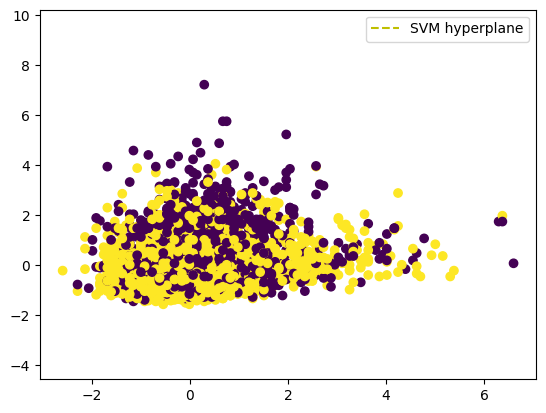

              precision    recall  f1-score   support

     bad[-1]       0.37      1.00      0.54       398
     good[1]       0.00      0.00      0.00       666

    accuracy                           0.37      1064
   macro avg       0.19      0.50      0.27      1064
weighted avg       0.14      0.37      0.20      1064



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [100]:
#importlib.reload(SVM_Module) # in case of manual updates on colab

svm = SVM(lambda_param=0.1)
# svm.fit(transformed_X_train_standard, y_train)
# predictions = svm.predict(transformed_X_test_standard)
svm.fit(X_train_standard, y_train)
predictions = svm.predict(X_test_standard)
#svm.fit(X_train, y_train)
#predictions = svm.predict(X_test)

accuracy = np.sum(predictions == y_test) / len(y_test)
print(f'Acc.:{accuracy}')

#print(inspect.signature(svm.visualize_svm))

svm.visualize_svm(X_train_standard, y_train)
#print(svm.weights)
#print(svm.bias)
print(classification_report(y_test, predictions, target_names=['bad[-1]', 'good[1]']))

#Logistic Regression

Acc.:0.6597744360902256


<Figure size 640x480 with 0 Axes>

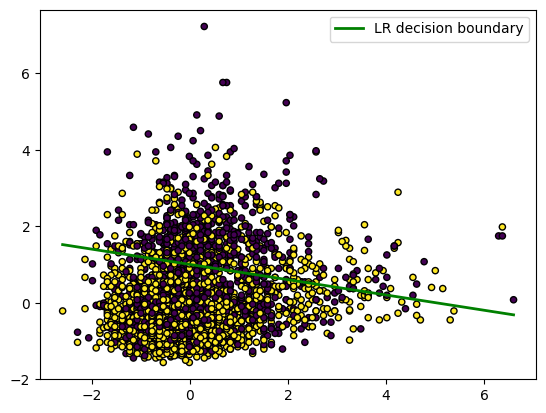

              precision    recall  f1-score   support

     bad[-1]       0.53      0.84      0.65       398
     good[1]       0.86      0.55      0.67       666

    accuracy                           0.66      1064
   macro avg       0.69      0.70      0.66      1064
weighted avg       0.73      0.66      0.66      1064



In [101]:
#importlib.reload(LogisticRegression_Module) # in case of manual updates on colab

lr = LogisticRegression()
# lr.fit(transformed_X_train_standard, y_train)
# predictions = lr.predict(transformed_X_test_standard)
lr.fit(X_train_standard, y_train)
predictions = lr.predict(X_test_standard)
#lr.fit(X_train, y_train)
#predictions = lr.predict(X_test)

accuracy = np.sum(predictions == y_test) / len(y_test)
print(f'Acc.:{accuracy}')

#print(inspect.signature(lr.visualize_svm))

lr.visualize_LR(X_train_standard, y_train)
#print(lr.weights)
#print(lr.bias)
print(classification_report(y_test, predictions, target_names=['bad[-1]', 'good[1]']))